In [1]:
from scipy.stats import nbinom,poisson,beta,expon,gamma,betaprime,uniform, cauchy, norm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import quad
from scipy.optimize import fixed_point
from scipy.special import gammaln,logsumexp
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

## Theoric

In [2]:
def logBF_theo_y(y):
    N = len(y)
    S = np.sum(y)
    return gammaln(N+S+2)-(S+1)*np.log(N+1)-np.sum(gammaln(y+1))-gammaln(N+1)

def logBF_theo_S(S,N):
    return (S-1)*np.log(N)+np.log(N+S)+np.log(N+S+1)-(S+1)*np.log(N+1)

## Bridge

In [3]:

from scipy.optimize import fixed_point
from scipy.special import logsumexp
def func_logBF_logsumexp(logBF,lratio_num,lratio_den):
    num_j = np.array([logsumexp([0,logBF+lratio_num[j]]) for j in range(len(lratio_num))])
    den_i = np.array([logsumexp([lratio_den[i],logBF]) for i in range(len(lratio_den))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den

def logBF_logsumexp_fixedpoint(lratio_num,lratio_den):
    return fixed_point(func_logBF_logsumexp,0,args=(lratio_num,lratio_den))

In [4]:
def func_r_paper(r,l1,l2,lstar):
    return np.sum(np.exp(l2-lstar)/(np.exp(l2-lstar)+r))/np.sum(1/(np.exp(l1-lstar)+r))


def BF_paper(l1,l2,method = "del2"):
    lstar = np.median(l1)
    r = fixed_point(func_r_paper,np.exp(-lstar),args=(l1,l2,lstar),maxiter=100,method=method)
    BF = r*np.exp(lstar)
    return BF

def func_logBF_paper(logBF,l1,l2):
    num_j = np.array([logsumexp([0,logBF-l2[j]]) for j in range(len(l2))])
    den_i = np.array([logsumexp([l1[i],logBF]) for i in range(len(l1))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den

def logBF_paper(l1,l2,method = "del2"):
    logBF = fixed_point(func_logBF_paper,1,args=(l1,l2),maxiter=100,method=method)
    return logBF

def func_BF_dumb(BF,l1,l2):
    num = np.sum(np.exp(l2)/(np.exp(l2)+BF))
    den = np.sum(1/(np.exp(l1)+BF))
    print("Numerator = {} Denominator = {} BF = {}".format(num,den,num/den))
    return num/den

def BF_dumb(l1,l2,method = "del2"):
    BF = fixed_point(func_BF_dumb,4,args=(l1,l2),maxiter=100,method=method)
    print("FIN\nNumerator = {}, Denominator = {} BF = {}".format(np.sum(np.exp(l2)/(np.exp(l2)+BF)),np.sum(1/(np.exp(l1)+BF)),BF))
    return BF

In [5]:
def logratio_pois_nb(mu,y):
    S,N = np.sum(y),len(y)
    return -mu*(N+1)+(N+S+2)*np.log(1+mu)-np.sum(gammaln(y+1))

In [6]:
from scipy.stats import multinomial
def sample_X_poiss_given_S(S,N,T):
    return multinomial.rvs(n=S, p=[1/N]*N,size=T)
    
def sample_nbinom(S,N):
    index = np.random.choice(N+S-1,N-1, replace=False)
    vect = np.append(np.sort(index),N+S-1)
    vect = np.append(-1,vect)
    return vect[1:]-vect[:-1]-1

def sample_X_nbinom_given_S(S,N,T):
    return np.array([sample_nbinom(S,N) for _ in range(T)]) 


In [7]:
def post_p_nbinom_unif(S,N,size):
    return beta(1+N,S+1).rvs(size)

def post_nbinom_unif(S,N,size):
    return betaprime(S+1,N+1).rvs(size)

def post_pois_exp(S,N,size):
    return gamma(S+1,scale=1/(N+1)).rvs(size)

In [8]:
def func_BF(args):
    np.random.seed()
    i,S,N,T = args
    X_poiss_S = sample_X_poiss_given_S(S,N,T)
    X_nb_S = sample_X_nbinom_given_S(S,N,T)
    mu_poiss = post_pois_exp(S,N,T)
    mu_nb = post_nbinom_unif(S,N,T)
    l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
    l2 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S)])

    Bridge = BF_paper(l1,l2)
    return Bridge

In [9]:
N =50
S_list = np.linspace(0,200,11).astype(int)
S_list

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200])

In [10]:
N = 50 
S_list = np.linspace(0,200,11).astype(int)
T = 100000
n_iter = 100
Theo_list, Bridge_list = [],[]
for S in S_list:
    print("S = {}".format(S))
    Bridge_S =[]
    lorgBridge_S = []
    Theo = np.exp(logBF_theo_S(S,N))
    for _ in tqdm(range(n_iter)):
        Bridge = func_BF((_,S,N,T))
        Bridge_S.append(Bridge)
    Theo_list.append(Theo)
    Bridge_list.append(Bridge_S)


S = 0


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [08:30<00:00,  5.10s/it]


S = 20


100%|██████████| 100/100 [08:48<00:00,  5.28s/it]


S = 40


100%|██████████| 100/100 [09:15<00:00,  5.55s/it]


S = 60


100%|██████████| 100/100 [09:16<00:00,  5.56s/it]


S = 80


100%|██████████| 100/100 [09:24<00:00,  5.65s/it]


S = 100


100%|██████████| 100/100 [09:35<00:00,  5.75s/it]


S = 120


100%|██████████| 100/100 [09:30<00:00,  5.71s/it]


S = 140


100%|██████████| 100/100 [09:35<00:00,  5.75s/it]


S = 160


100%|██████████| 100/100 [09:39<00:00,  5.80s/it]


S = 180


100%|██████████| 100/100 [10:02<00:00,  6.03s/it]


S = 200


100%|██████████| 100/100 [10:07<00:00,  6.08s/it]


In [24]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


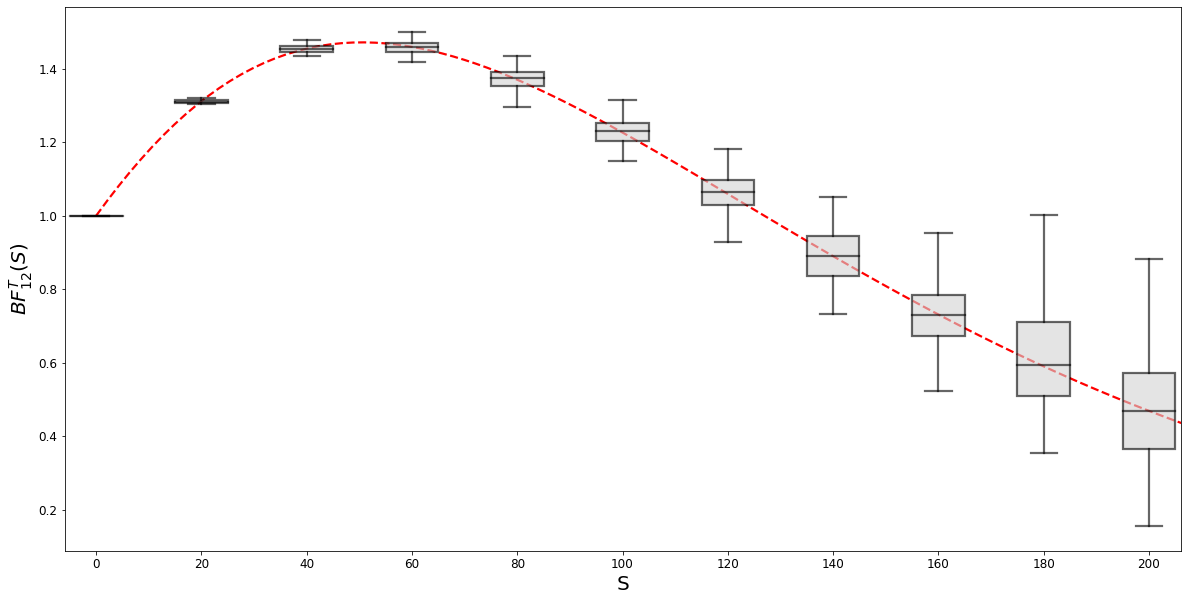

In [44]:
c1 = "black"
c2 = "lightgrey"
N = 50
plt.figure(figsize=(20, 10))
lw=2.2
alpha=.6

S_theo = np.linspace(0,210,100)
BF_theo = [np.exp(logBF_theo_S(S,N)) for S in S_theo]
plt.plot(S_theo, BF_theo, color="red", linestyle='--', label='Theoretical value',alpha=1, linewidth=lw)


plt.boxplot(list((Bridge_list)), positions=S_list, widths=N/5, patch_artist=True, showfliers=False, 
            boxprops=dict(facecolor=c2, edgecolor=c1, linewidth=lw, alpha=alpha), 
            whiskerprops=dict(color=c1, linewidth=lw,alpha=alpha), 
            medianprops=dict(color=c1, linewidth=lw,alpha=alpha), 
            capprops=dict(color=c1, linewidth=lw,alpha=alpha))



plt.xlabel('S', fontsize=20)

plt.ylabel('$BF_{12}^{T}(S)$', fontsize=20)
plt.xlim(-6, 206)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)



plt.savefig("Fig7.png", format = "png", bbox_inches='tight', dpi= 500)
plt.savefig("Fig7.pdf", format = "pdf", bbox_inches='tight', dpi= 500)
plt.show()
